In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tqdm import trange, tqdm
from oasis.functions import deconvolve
print(os.getcwd())
os.chdir('..')
from load_data import read_Decoding_csv, load_neural_npz
from load_stimulus_data import build_drift_grating_stim, build_static_grating_stim, build_nature_scenes_grating_stim, build_nature_movie_grating_stim, stimulus_mat2vec, get_contained_names,create_stimulus_mat
os.chdir('..')
print(os.getcwd())

def continuous_discrete_MI(X_continuous, Y_discrete):
    """
    X_continuous: shape (ts,)，神经响应（如钙信号）
    Y_discrete: shape (ts,)，刺激类别
    """
    classes = np.unique(Y_discrete)
    mi = 0
    for c in classes:
        idx = (Y_discrete == c)
        p_c = np.mean(idx)
        if p_c == 0:
            continue
        X_c = X_continuous[idx].reshape(-1, 1)
        k = min(5, len(X_c) - 1)
        if k < 2:
            continue
        nbrs = NearestNeighbors(n_neighbors=k).fit(X_c)
        distances = nbrs.kneighbors(X_c)[0].mean(axis=1)
        mi += p_c * np.log(distances + 1e-10).mean()
    return -mi


# load data
def create_session_data(Target_Brain_region = 'VISal', data_root='data', session_letter='B'):
    # Target_Brain_region = 'VISal'
    # data_root = 'data'
    sessions = [session_letter]
    session_datas = []
    session_folders = [] 
    for session in sessions:
        tgt_dict, tgt_folder = read_Decoding_csv(data_path=data_root,region_type = Target_Brain_region, session_letter = session)
        session_datas.append(tgt_dict)
        session_folders.append(tgt_folder)
    print('================================================')
    print(session_folders)

    ts_sessions = []
    dff_sessions = []
    all_roi_masks_sessions = []
    cids_sessions = []
    metadata_sessions = []
    spike_info_sessions = []
    information_dicts = {}


    for tgt_data_path in session_folders:
        for file_name in os.listdir(os.path.join(data_root, tgt_data_path)):
            if file_name.endswith('.npz'):
                ts, dff, all_roi_masks, cids, metadata = load_neural_npz(os.path.join(data_root, tgt_data_path,file_name))
                ts_sessions.append(ts)
                dff_sessions.append(dff)
                all_roi_masks_sessions.append(all_roi_masks)
                cids_sessions.append(cids)
                metadata_sessions.append(metadata)
                spike_info_sessions.append(np.array([deconvolve(dff[_i,:], penalty=1)[1] for _i in trange(dff.shape[0])]))
                position = metadata.tolist()
                print('================================================')
                print('Caution, the position of this file is about the brain part of', position['targeted_structure'])
                print('================================================')
            elif file_name.endswith('.csv') and file_name.find('Decoding') == -1:
                information_dicts[file_name.split('.')[0]] = pd.read_csv(os.path.join(data_root, tgt_data_path,file_name))  
    print('================================================')
    if 'stimulus_metadata_natural_movie_one' in information_dicts.keys() and 'stimulus_metadata_natural_movie_three' in information_dicts.keys():
        information_dicts['stimulus_metadata_natural_movie'] = pd.concat([information_dicts['stimulus_metadata_natural_movie_one'],information_dicts['stimulus_metadata_natural_movie_three']])
        information_dicts.pop('stimulus_metadata_natural_movie_one')
        information_dicts.pop('stimulus_metadata_natural_movie_three')
    print(information_dicts.keys())
    return ts_sessions,  dff_sessions, all_roi_masks_sessions , cids_sessions, metadata_sessions, spike_info_sessions, information_dicts


e:\miniconda\conda\envs\SCNS\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


d:\生科课\计算与系统神经科学\SCNSProject\src\forwardNetworkModels
d:\生科课\计算与系统神经科学\SCNSProject


we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three-al.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_total.csv
['VISal_three_session_A_501876401']
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']


100%|██████████| 181/181 [00:08<00:00, 22.28it/s]


Caution, the position of this file is about the brain part of VISal
dict_keys(['stimulus_metadata_drifting_gratings', 'stimulus_metadata_natural_movie_one', 'stimulus_metadata_natural_movie_three-al', 'stimulus_metadata_spontaneous', 'stimulus_metadata_total'])
dict_keys(['drifting_gratings', 'natural_movie', 'spontaneous'])
timelength =  115492


599it [00:00, 23037.60it/s]


Drift grating stimulus_mat.shape =  (41, 115492)
(41, 115492)
selected_spikes.shape (181, 36604)


100%|██████████| 181/181 [00:43<00:00,  4.18it/s]


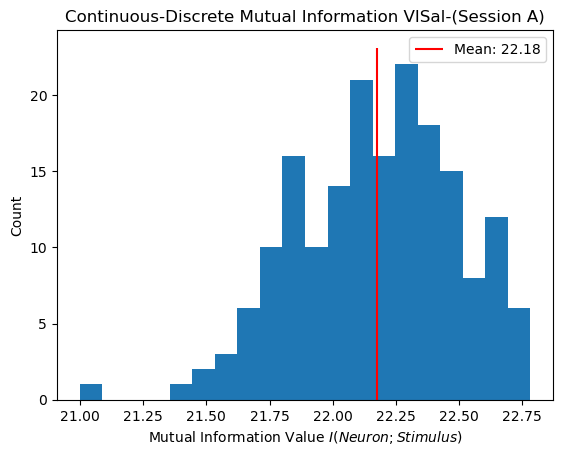

In [10]:
Target_Brain_region = 'VISal'
data_root = 'data'
session_letter = 'A'
ts_sessions,  dff_sessions, all_roi_masks_sessions , cids_sessions, metadata_sessions, spike_info_sessions, information_dicts = create_session_data(Target_Brain_region = Target_Brain_region, data_root=data_root, session_letter=session_letter)
contained_names, contained_keys = get_contained_names(information_dicts)
total_stimulus = create_stimulus_mat(contained_names,ts=ts_sessions[0])
stimulus_vec = stimulus_mat2vec(total_stimulus)
selected_ts = np.where(stimulus_vec!=0)[0]
selected_vec = stimulus_vec[selected_ts]
selected_spikes = spike_info_sessions[0][:,selected_ts]
print('selected_spikes.shape',selected_spikes.shape)
cdmis = [continuous_discrete_MI(selected_spikes[_i,:],selected_vec) for _i in trange(selected_spikes.shape[0])]
plt.hist(cdmis, bins=20)
plt.title(f'Continuous-Discrete Mutual Information {Target_Brain_region}-(Session {session_letter})')
plt.vlines(x=np.mean(cdmis),ymin=0,ymax=np.max(plt.gca().get_ylim()),color='red')
plt.legend(['Mean: {:.2f}'.format(np.mean(cdmis))])
plt.xlabel('Mutual Information Value $I(Neuron;Stimulus)$')
plt.ylabel('Count')
plt.show()

we have keys in data_dict, including:
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_scenes.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_static_gratings.csv
stimulus_metadata_total.csv
['VISal_three_session_B_501929146']
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']


100%|██████████| 172/172 [00:07<00:00, 22.16it/s]


Caution, the position of this file is about the brain part of VISal
dict_keys(['stimulus_metadata_natural_movie_one', 'stimulus_metadata_natural_scenes', 'stimulus_metadata_spontaneous', 'stimulus_metadata_static_gratings', 'stimulus_metadata_total'])
dict_keys(['static_gratings', 'natural_scenes', 'natural_movie', 'spontaneous'])
timelength =  113852


5805it [00:00, 24130.61it/s]


Static grating stimulus_mat.shape =  (121, 113852)
(121, 113852)
selected_spikes.shape (172, 41794)


100%|██████████| 172/172 [00:33<00:00,  5.06it/s]


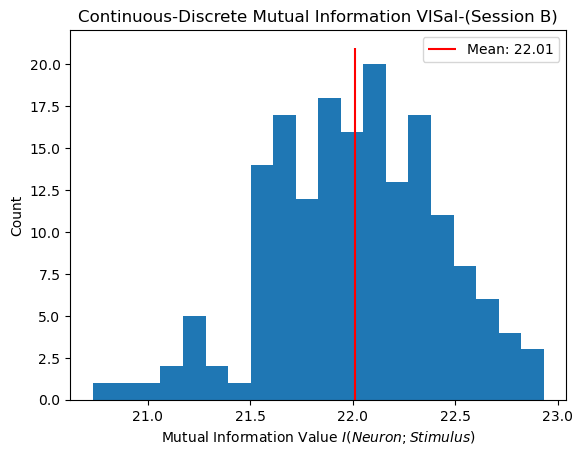

In [11]:
Target_Brain_region = 'VISal'
data_root = 'data'
session_letter = 'B'
ts_sessions,  dff_sessions, all_roi_masks_sessions , cids_sessions, metadata_sessions, spike_info_sessions, information_dicts = create_session_data(Target_Brain_region = Target_Brain_region, data_root=data_root, session_letter=session_letter)
contained_names, contained_keys = get_contained_names(information_dicts)
total_stimulus = create_stimulus_mat(contained_names,ts=ts_sessions[0])
stimulus_vec = stimulus_mat2vec(total_stimulus)
selected_ts = np.where(stimulus_vec!=0)[0]
selected_vec = stimulus_vec[selected_ts]
selected_spikes = spike_info_sessions[0][:,selected_ts]
print('selected_spikes.shape',selected_spikes.shape)
cdmis = [continuous_discrete_MI(selected_spikes[_i,:],selected_vec) for _i in trange(selected_spikes.shape[0])]
plt.hist(cdmis, bins=20)
plt.title(f'Continuous-Discrete Mutual Information {Target_Brain_region}-(Session {session_letter})')
plt.vlines(x=np.mean(cdmis),ymin=0,ymax=np.max(plt.gca().get_ylim()),color='red')
plt.legend(['Mean: {:.2f}'.format(np.mean(cdmis))])
plt.xlabel('Mutual Information Value $I(Neuron;Stimulus)$')
plt.ylabel('Count')
plt.show()

we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_total.csv
['VISl_three_session_A_502793808']
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']


100%|██████████| 153/153 [00:07<00:00, 21.56it/s]


Caution, the position of this file is about the brain part of VISl
dict_keys(['stimulus_metadata_drifting_gratings', 'stimulus_metadata_spontaneous', 'stimulus_metadata_total', 'stimulus_metadata_natural_movie'])
dict_keys(['drifting_gratings', 'natural_movie', 'spontaneous'])
timelength =  115469


598it [00:00, 22084.61it/s]


Drift grating stimulus_mat.shape =  (41, 115469)
(41, 115469)
selected_spikes.shape (153, 36590)


100%|██████████| 153/153 [00:37<00:00,  4.08it/s]


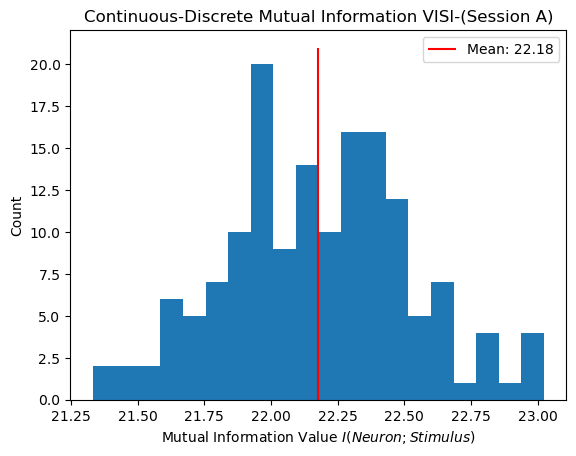

In [12]:
Target_Brain_region = 'VISl'
data_root = 'data'
session_letter = 'A'
ts_sessions,  dff_sessions, all_roi_masks_sessions , cids_sessions, metadata_sessions, spike_info_sessions, information_dicts = create_session_data(Target_Brain_region = Target_Brain_region, data_root=data_root, session_letter=session_letter)
contained_names, contained_keys = get_contained_names(information_dicts)
total_stimulus = create_stimulus_mat(contained_names,ts=ts_sessions[0])
stimulus_vec = stimulus_mat2vec(total_stimulus)
selected_ts = np.where(stimulus_vec!=0)[0]
selected_vec = stimulus_vec[selected_ts]
selected_spikes = spike_info_sessions[0][:,selected_ts]
print('selected_spikes.shape',selected_spikes.shape)
cdmis = [continuous_discrete_MI(selected_spikes[_i,:],selected_vec) for _i in trange(selected_spikes.shape[0])]
plt.hist(cdmis, bins=20)
plt.title(f'Continuous-Discrete Mutual Information {Target_Brain_region}-(Session {session_letter})')
plt.vlines(x=np.mean(cdmis),ymin=0,ymax=np.max(plt.gca().get_ylim()),color='red')
plt.legend(['Mean: {:.2f}'.format(np.mean(cdmis))])
plt.xlabel('Mutual Information Value $I(Neuron;Stimulus)$')
plt.ylabel('Count')
plt.show()

we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_natural_scenes.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_static_gratings.csv
stimulus_metadata_total.csv
['VISl_three_session_B_502526200']
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']


100%|██████████| 175/175 [00:08<00:00, 21.25it/s]


Caution, the position of this file is about the brain part of VISl
dict_keys(['stimulus_metadata_drifting_gratings', 'stimulus_metadata_natural_scenes', 'stimulus_metadata_spontaneous', 'stimulus_metadata_static_gratings', 'stimulus_metadata_total', 'stimulus_metadata_natural_movie'])
dict_keys(['drifting_gratings', 'static_gratings', 'natural_scenes', 'natural_movie', 'spontaneous'])
timelength =  113862


598it [00:00, 23918.77it/s]


Drift grating stimulus_mat.shape =  (41, 113862)
timelength =  113862


5806it [00:00, 24909.15it/s]


Static grating stimulus_mat.shape =  (121, 113862)
(162, 113862)
selected_spikes.shape (175, 52312)


  0%|          | 0/175 [00:00<?, ?it/s]Exception in thread Thread-12 (_readerthread):
Traceback (most recent call last):
  File "e:\miniconda\conda\envs\SCNS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "e:\miniconda\conda\envs\SCNS\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "e:\miniconda\conda\envs\SCNS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "e:\miniconda\conda\envs\SCNS\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "e:\miniconda\conda\envs\SCNS\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xce in position 4: invalid continuation byte
100%|██████████| 175/175 [00:50<00:00,  3.50it/s]


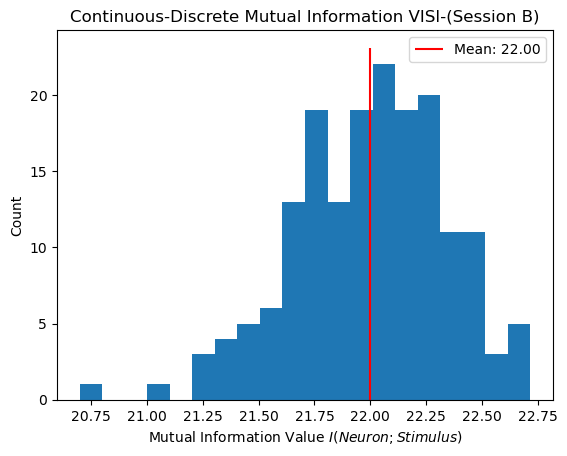

In [13]:
Target_Brain_region = 'VISl'
data_root = 'data'
session_letter = 'B'
ts_sessions,  dff_sessions, all_roi_masks_sessions , cids_sessions, metadata_sessions, spike_info_sessions, information_dicts = create_session_data(Target_Brain_region = Target_Brain_region, data_root=data_root, session_letter=session_letter)
contained_names, contained_keys = get_contained_names(information_dicts)
total_stimulus = create_stimulus_mat(contained_names,ts=ts_sessions[0])
stimulus_vec = stimulus_mat2vec(total_stimulus)
selected_ts = np.where(stimulus_vec!=0)[0]
selected_vec = stimulus_vec[selected_ts]
selected_spikes = spike_info_sessions[0][:,selected_ts]
print('selected_spikes.shape',selected_spikes.shape)
cdmis = [continuous_discrete_MI(selected_spikes[_i,:],selected_vec) for _i in trange(selected_spikes.shape[0])]
plt.hist(cdmis, bins=20)
plt.title(f'Continuous-Discrete Mutual Information {Target_Brain_region}-(Session {session_letter})')
plt.vlines(x=np.mean(cdmis),ymin=0,ymax=np.max(plt.gca().get_ylim()),color='red')
plt.legend(['Mean: {:.2f}'.format(np.mean(cdmis))])
plt.xlabel('Mutual Information Value $I(Neuron;Stimulus)$')
plt.ylabel('Count')
plt.show()

we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_spontaneous.csv
['VISp_three_session_A_501704220']
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']


100%|██████████| 142/142 [00:06<00:00, 22.42it/s]


Caution, the position of this file is about the brain part of VISp
dict_keys(['stimulus_metadata_drifting_gratings', 'stimulus_metadata_spontaneous', 'stimulus_metadata_natural_movie'])
dict_keys(['drifting_gratings', 'natural_movie', 'spontaneous'])
timelength =  115514


598it [00:00, 23919.00it/s]


Drift grating stimulus_mat.shape =  (41, 115514)
(41, 115514)
selected_spikes.shape (142, 36598)


100%|██████████| 142/142 [00:35<00:00,  4.01it/s]


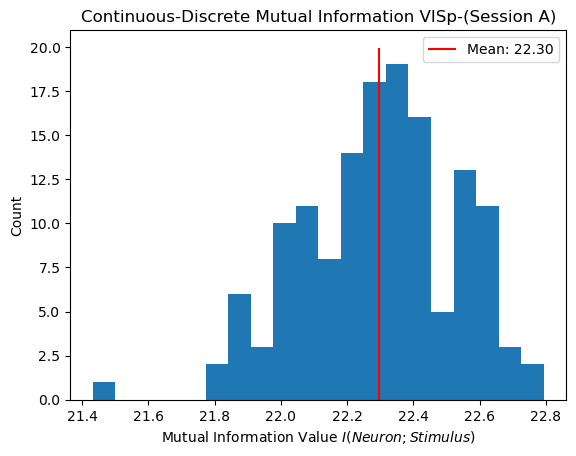

In [14]:
Target_Brain_region = 'VISp'
data_root = 'data'
session_letter = 'A'
ts_sessions,  dff_sessions, all_roi_masks_sessions , cids_sessions, metadata_sessions, spike_info_sessions, information_dicts = create_session_data(Target_Brain_region = Target_Brain_region, data_root=data_root, session_letter=session_letter)
contained_names, contained_keys = get_contained_names(information_dicts)
total_stimulus = create_stimulus_mat(contained_names,ts=ts_sessions[0])
stimulus_vec = stimulus_mat2vec(total_stimulus)
selected_ts = np.where(stimulus_vec!=0)[0]
selected_vec = stimulus_vec[selected_ts]
selected_spikes = spike_info_sessions[0][:,selected_ts]
print('selected_spikes.shape',selected_spikes.shape)
cdmis = [continuous_discrete_MI(selected_spikes[_i,:],selected_vec) for _i in trange(selected_spikes.shape[0])]
plt.hist(cdmis, bins=20)
plt.title(f'Continuous-Discrete Mutual Information {Target_Brain_region}-(Session {session_letter})')
plt.vlines(x=np.mean(cdmis),ymin=0,ymax=np.max(plt.gca().get_ylim()),color='red')
plt.legend(['Mean: {:.2f}'.format(np.mean(cdmis))])
plt.xlabel('Mutual Information Value $I(Neuron;Stimulus)$')
plt.ylabel('Count')
plt.show()

we have keys in data_dict, including:
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_scenes.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_static_gratings.csv
stimulus_metadata_total.csv
['VISp_three_session_B_501559087']
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']


100%|██████████| 174/174 [00:07<00:00, 22.44it/s]


Caution, the position of this file is about the brain part of VISp
dict_keys(['stimulus_metadata_natural_movie_one', 'stimulus_metadata_natural_scenes', 'stimulus_metadata_spontaneous', 'stimulus_metadata_static_gratings', 'stimulus_metadata_total'])
dict_keys(['static_gratings', 'natural_scenes', 'natural_movie', 'spontaneous'])
timelength =  113888


5808it [00:00, 24972.98it/s]


Static grating stimulus_mat.shape =  (121, 113888)
(121, 113888)
selected_spikes.shape (174, 41814)


100%|██████████| 174/174 [00:33<00:00,  5.26it/s]


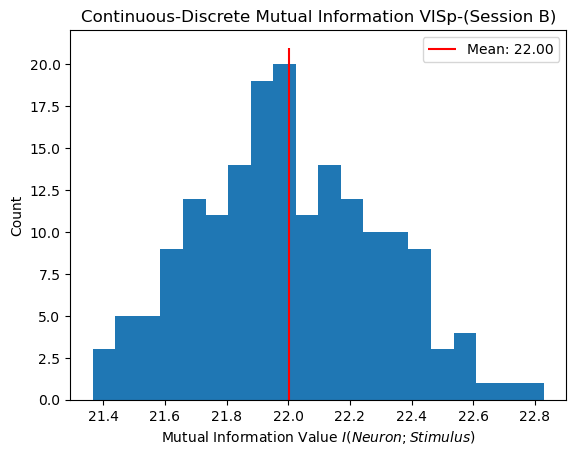

In [15]:
Target_Brain_region = 'VISp'
data_root = 'data'
session_letter = 'B'
ts_sessions,  dff_sessions, all_roi_masks_sessions , cids_sessions, metadata_sessions, spike_info_sessions, information_dicts = create_session_data(Target_Brain_region = Target_Brain_region, data_root=data_root, session_letter=session_letter)
contained_names, contained_keys = get_contained_names(information_dicts)
total_stimulus = create_stimulus_mat(contained_names,ts=ts_sessions[0])
stimulus_vec = stimulus_mat2vec(total_stimulus)
selected_ts = np.where(stimulus_vec!=0)[0]
selected_vec = stimulus_vec[selected_ts]
selected_spikes = spike_info_sessions[0][:,selected_ts]
print('selected_spikes.shape',selected_spikes.shape)
cdmis = [continuous_discrete_MI(selected_spikes[_i,:],selected_vec) for _i in trange(selected_spikes.shape[0])]
plt.hist(cdmis, bins=20)
plt.title(f'Continuous-Discrete Mutual Information {Target_Brain_region}-(Session {session_letter})')
plt.vlines(x=np.mean(cdmis),ymin=0,ymax=np.max(plt.gca().get_ylim()),color='red')
plt.legend(['Mean: {:.2f}'.format(np.mean(cdmis))])
plt.xlabel('Mutual Information Value $I(Neuron;Stimulus)$')
plt.ylabel('Count')
plt.show()

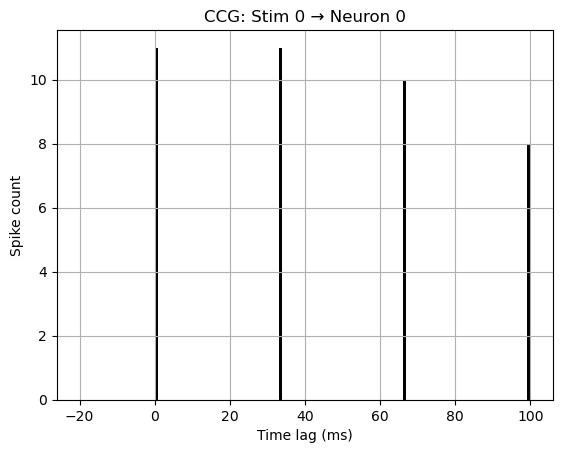

In [5]:
# thus we have two different important matrixes: one is the firing_data, another is the almost one-hot feature_list
# we now want to compute the similarity between them
# use the similarity_metric of CCG

def compute_ccg(trigger_times, neuron_spikes, window=(-50, 50), bin_size=1, fs=1000):
    """
    已经弃用了，原因是CCG要求非常高精度的时间数据，而钙成像数据的速度相当慢，两帧之间的时间间隔在33.3ms左右，1/30s，这是不能够容忍的。
    尤其是我们一般会认为可能在几个毫秒甚至微秒就能够完成所有任务。
    计算刺激触发下的神经元交叉相关图
    :param trigger_times: 刺激出现的时间点 (单位: 时间步)
    :param neuron_spikes: 神经元的 spike 序列 (0/1 数组)
    :param window: 时间窗口 (ms)
    :param bin_size: bin 大小 (ms)
    :param fs: 采样率 (Hz or time steps per second)
    :return: bins, ccg
    """
    ms_to_step = fs / 1000
    window_steps = np.round(np.array(window) * ms_to_step).astype(int)
    bins = np.arange(window[0], window[1] + bin_size, bin_size)
    ccg = np.zeros_like(bins[:-1])

    for t in trigger_times:
        start_idx = t + window_steps[0]
        end_idx = t + window_steps[1]
        if start_idx < 0 or end_idx >= len(neuron_spikes):
            continue
        sub_spike = neuron_spikes[start_idx:end_idx]
        time_diffs = np.where(sub_spike)[0]
        time_diffs_ms = time_diffs * (1000 / fs)
        ccg += np.histogram(time_diffs_ms, bins=bins)[0]

    return bins[:-1], ccg

fs = 30  # 假设时间分辨率为 1ms per step

# 选一个刺激通道和一个神经元做示例
stim_idx = 0
neuron_idx = 0

trigger_times = np.where(total_stimulus[stim_idx] == 1)[0]
neuron_spikes = spike_info_sessions[0][neuron_idx]

# 计算 CCG
window = (-20, 100)  # 查看前后 50ms 的响应
bin_size = 1  # 每 2ms 一个 bin

bins, ccg = compute_ccg(trigger_times, neuron_spikes, window=window, bin_size=bin_size, fs=fs)
bins = bins
# 绘图
plt.bar(bins, ccg, width=bin_size, align='edge', color='k')
plt.xlabel('Time lag (ms)')
plt.ylabel('Spike count')
plt.title(f'CCG: Stim {stim_idx} → Neuron {neuron_idx}')
plt.grid(True)
plt.show()